Задание:
- Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?
- Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)
- Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?
- Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.
- Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?


In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import collections
import scipy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv("./credit_card_default_analysis.csv")
df.head(3)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0


Данные:
- LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
- SEX: пол клиента (1 = мужской, 2 = женский )
- EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
- MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
- AGE: возраст в годах
- PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
- BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
- PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
- default - индикатор невозврата денежных средств

# 1. LIMIT_BAL

Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

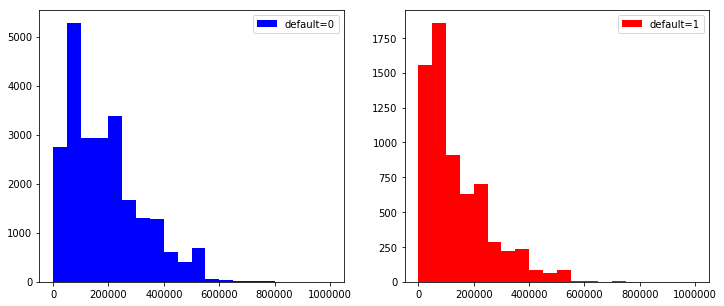

In [3]:
data1 = df.loc[df.default==0, 'LIMIT_BAL'].reset_index(drop=True)
data2 = df.loc[df.default==1, 'LIMIT_BAL'].reset_index(drop=True)

pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(data1.tolist(), bins=20, color='b', range=(0, 1e6), label='default=0')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(data2.tolist(), bins=20, color='r', range=(0, 1e6), label='default=1')
pylab.legend()

pylab.show()

## 1.1 Проверим гипотезу  равенстве медиан через бутстрап итервалы

In [4]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def get_bootstrap_medians(data1,data2, n_samples):
    res = []
    for _ in range(n_samples):
        idx1 = np.random.randint(0, len(data1)-1, len(data1))
        idx2 = np.random.randint(0, len(data2)-1, len(data2))
        samples1 = data1[idx1.tolist()]
        samples2 = data2[idx2.tolist()]
        res.append(np.median(samples1) - np.median(samples2))
    return res

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries


In [5]:
n_samples = 1000
m1 = np.median(get_bootstrap_samples(data1.values, n_samples), axis=1)
m2 = np.median(get_bootstrap_samples(data2.values, n_samples), axis=1)
diff = m1-m2

print "95% доверителный интервал",stat_intervals(diff, 0.05)

95% доверителный интервал [60000. 70000.]


Интервал не пересекает 0, это значит что с уровнем значимости 0.05 можно утверждать, что медианы не равны. На основе допущение что неравенства медиан достаточно чтобы считать выборки неравными, выборки не равны;

## 1.2 Проверим гипотезу равестве выборок через перестановочный тест

Воспользуемся перестановочным критерием, нужно иметь ввиду что перестановочный критерий предполагаем следующие допущения:
- функции рапределения равны по форме
- рассматривается только сдвиг, другие виды отличия не рассматриваются данным критерием

In [6]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [7]:
print "p-value: %f" % permutation_test(data1, data2, max_permutations = 10000)

p-value: 0.000100


Согласно перестановочному тесту, выборки отличаются с уровнем значимости 0.05. Практическая значимость мы рассмотрена в предыдущем пункте.

## 1.3 Практическая значимость
Теперь рассмотрим практическую значимость.

In [8]:
print "Среднее отклонение медиан составляет %.2f рублей"%diff.mean()

Среднее отклонение медиан составляет 60455.00 рублей


Данное отклонение является практически значимым.

# 2. Пол (SEX)

Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

Н0 - гендерный состав не отличается  
Н1 - есть различия по гендерному составу

In [9]:
d_male_1 = df.loc[df.default==0, "SEX"]==1
d_male_2 = df.loc[df.default==1, "SEX"]==2

m_male_1 = sum(d_male_1)
m_male_2 = sum(d_male_2)

n_male_1 = len(d_male_1)
n_male_2 = len(d_male_2)


p_male_1 = float(m_male_1)/float(n_male_1)
p_male_2 = float(m_male_2)/float(n_male_2)

Text(0.5,1,'SEX[default=1]')

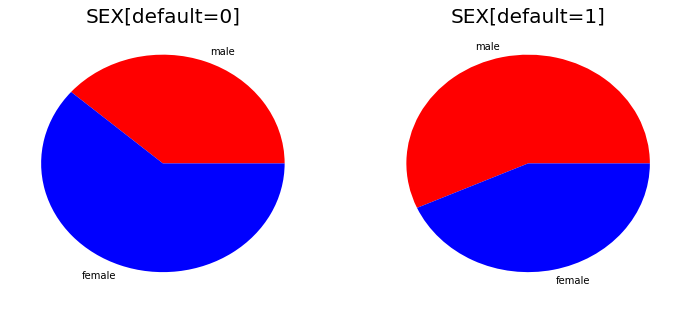

In [10]:
fig, axs = pylab.subplots(1, 2)

axs[0].pie([p_male_1,1-p_male_1], colors='rb', labels=["male", "female"])
axs[0].set_title("SEX[default=0]", fontsize=20)
axs[1].pie([p_male_2, 1-p_male_2], colors='rb', labels=["male", "female"])
axs[1].set_title("SEX[default=1]", fontsize=20)

По графикам видно, что различия практически значимы.

## 2.1 Метод доверительных интервалов

Поскольку у нас имеется только два значения, то мы можем применить интервальную оценку долей.

In [11]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [12]:

print "95% доверительный интервал: ", proportions_confint_diff_ind(d_male_1, d_male_2)


95% доверительный интервал:  (-0.194665015889303, -0.16775187066403494)


## 2.2 Метод стат-тестов

Поскольку у нас имеется только два значения, то мы можем применить статистический критерий для долей между несвязными выборками.

In [13]:
P = float(m_male_1 + m_male_2)/float(n_male_1 + n_male_2)
z = (p_male_1 - p_male_2)/(P*(1 - P)*(1./n_male_1 + 1./n_male_2))**.5

print 2*(1 - stats.norm.cdf(np.abs(z)))

0.0


Пол можно считать значимым для уровня значимости 0.05. 

## 2.3 Практическая значимость

Рассмотрим практическую значимость.

In [14]:
print "Разница долей составляет", p_male_1-p_male_2

Разница долей составляет -0.181208443277


Различие можно считать практически значимым.

# 3. Образование (EDUCATION)

Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

## 3.1 Статистический критерий

Нам необходимо проверить гипотезу о значимости категориального признак:

Н0 - частоты уровней образования состав не отличаются между значениями целевой переменной  
Н1 - есть различие в семейном составе  

Для этого воспользуемс критерием хи-квадрат.

In [15]:
df.groupby("EDUCATION")["default"].agg(["sum","count","mean"])

,sum,count,mean
EDUCATION,,,
0,0,14,0.000000
1,2036,10585,0.192348
2,3330,14030,0.237349
3,1237,4917,0.251576
4,7,123,0.056911
5,18,280,0.064286
6,8,51,0.156863


1. mean - столбец, который отображает значения без влияния масштаба
2. Образование 3 (выпускник школы) - наибольший процент возврата
3. Образование 0 (доктор наук) - наименьший процент возврата

Проверим, применимость хи-квадрат критерия. Посчитаем количество наблюдений для каждой пары "категория-отклик".

In [16]:
df.groupby(["EDUCATION", "default"]).size()

EDUCATION  default
0          0             14
1          0           8549
           1           2036
2          0          10700
           1           3330
3          0           3680
           1           1237
4          0            116
           1              7
5          0            262
           1             18
6          0             43
           1              8
dtype: int64

Только одна пара нарушает условие, что число наблюдей должно быть больше пяти, что не превышает 20%. Это пара <EDUCATION=0, default=1>. Очевидно, что общее число наблюдений не меньше 40.

Следоательно, мы можем применить критерий хи-квадрат.

In [17]:
edu_df = df[["EDUCATION", "default"]].pivot_table(index="EDUCATION", columns="default", aggfunc=len).fillna(0)
edu_df


default,0,1
EDUCATION,,
0,14.0,0.0
1,8549.0,2036.0
2,10700.0,3330.0
3,3680.0,1237.0
4,116.0,7.0
5,262.0,18.0
6,43.0,8.0


In [18]:
_, pvalue, _, expected =stats.chi2_contingency(edu_df.values)
print "p-value=", pvalue

p-value= 1.2332626245415605e-32


p-value это маленькая величина порядка 1е-32, образование можно считать значимым признаком для уровня значимости 0.05

## 3.2 Различие между ожидаемым и реальным значениями

Построим таблицу сопряженности различий между ожидаемым и реальными значениями

In [19]:
diff_tbl = pd.DataFrame(edu_df.values - expected)
diff_tbl.index.rename("EDUCATION", inplace=True)
diff_tbl

,0,1
EDUCATION,,
0,3.0968,-3.0968
1,305.4020,-305.4020
2,-226.5640,226.5640
3,-149.3596,149.3596
4,20.2076,-20.2076
5,43.9360,-43.9360
6,3.2812,-3.2812


# 4. Семейное положение (MARRIAGE)

Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

In [20]:
df.groupby(["MARRIAGE", "default"]).size()

MARRIAGE  default
0         0             49
          1              5
1         0          10453
          1           3206
2         0          12623
          1           3341
3         0            239
          1             84
dtype: int64

Нам необходимо проверить гипотезу о значимости категориального признака:

Н0 - семейный состав не отличается  
Н1 - есть различие в семейном составе  

Для этого воспользуемс критерием хи-квадрат.


In [21]:
mar_df = df[["EDUCATION", "default"]].pivot_table(index="EDUCATION", columns="default", aggfunc=len).fillna(0)
mar_df


default,0,1
EDUCATION,,
0,14.0,0.0
1,8549.0,2036.0
2,10700.0,3330.0
3,3680.0,1237.0
4,116.0,7.0
5,262.0,18.0
6,43.0,8.0


Количество пар, где число наблюдей должно быть больше пяти, не превышает 20%. И очевидно, что общее число наблюдение больше 40. Что позволяет применить критерий хи-квадрат.

In [22]:
measure, pvalue, _, _ =stats.chi2_contingency(mar_df.values)
print "p-value=", pvalue

p-value= 1.2332626245415605e-32


p-value это маленькая величина порядка 1е-32, семейное положение можно считать значимым признаком для уровня значимости 0.05

Посчитаем коэффициент Крамера

In [23]:
print "V=", measure/np.sum(mar_df.values)/(np.min(mar_df.shape)-1)**.5

V= 0.0054405519289990245


Коэффициент Крамера очень мал - взаимосвязь между семйным положением и целевой переменой очень мала, что заставляет усомниться в практической значимости семейного положения как признака.

# 5. Возраст (AGE)

Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

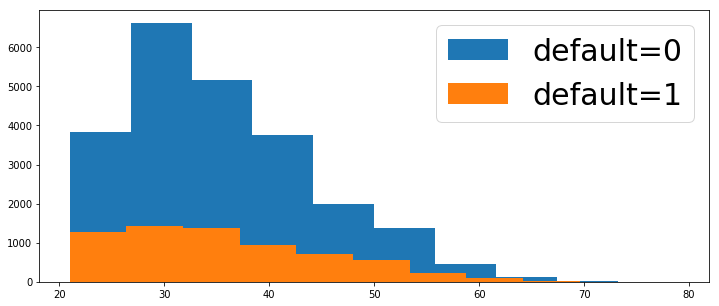

In [24]:
age0 = df.loc[df.default==0, 'AGE']
age1 = df.loc[df.default==1, 'AGE']

pylab.hist(age0, label="default=0")
pylab.hist(age1, label="default=1")

pylab.legend(loc=1, prop={'size': 30})

## 5.1 Интервальная оценка

In [25]:
n_samples = 1000
m1 = np.median(get_bootstrap_samples(age0.values, n_samples), axis=1)
m2 = np.median(get_bootstrap_samples(age1.values, n_samples), axis=1)
diff = m1-m2

print "95% доверителный интервал",stat_intervals(diff, 0.05)

95% доверителный интервал [-1.  0.]


Доверительный интервал касается ноль краем отрезка, интервальная оценка не дает информации о значимости возраста.

## 5.2 Критерий значимости

In [26]:
print "p-value: %f" % permutation_test(age0, age1, max_permutations = 10000)

p-value: 0.018200


p-value не превышает 0.05, возраст является значимым признаком.

## 5.3 Практическая значимость

Проверим практическую значимость:

In [27]:
print "Разница медиан составляет ", diff.mean(), "+/-", diff.std()

Разница медиан составляет  -0.094 +/- 0.29011032384249963


Практическая значимость такого различия сомнительна.